# Reverse time migration example on a 2D  acoustic model

## Set up environment.

In [1]:
from ipyparallel import Client
c = Client(profile='mpi')
dview = c[:]

with dview.sync_imports():
    import sys
    import numpy
    from examples.acoustic import demo_toolkit
    from examples.acoustic.Acoustic_codegen import Acoustic_cg

# Setup figure size
%matplotlib inline

import matplotlib.pyplot as plt
fig_size = [0, 0]
fig_size[0] = 18
fig_size[1] = 13
plt.rcParams["figure.figsize"] = fig_size

importing sys on engine(s)
importing numpy on engine(s)
importing demo_toolkit from examples.acoustic on engine(s)
importing Acoustic_cg from examples.acoustic.Acoustic_codegen on engine(s)


## Load synthetic velocity model.

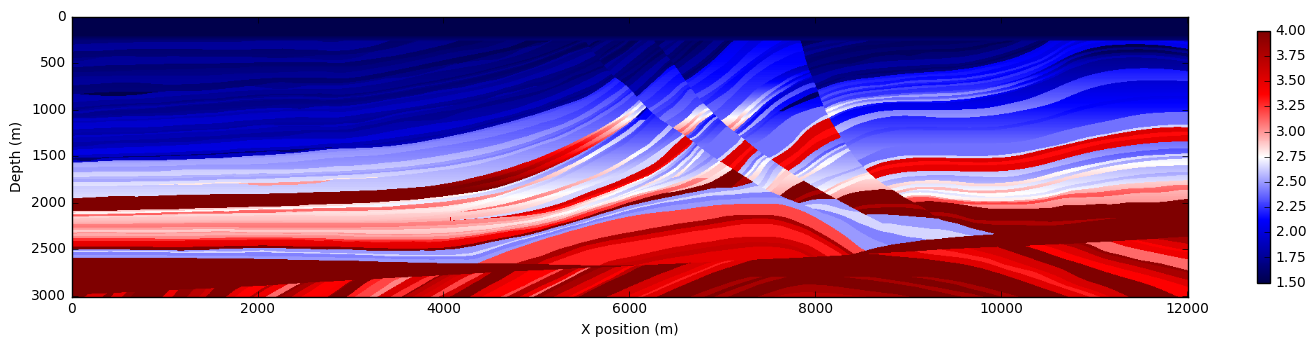

In [2]:
demo = demo_toolkit.marmousi2D()
model = demo.get_true_model()

demo.plot_velocity(model.vp)

## Create "initial guess" by smoothening the synthetic velocity model.

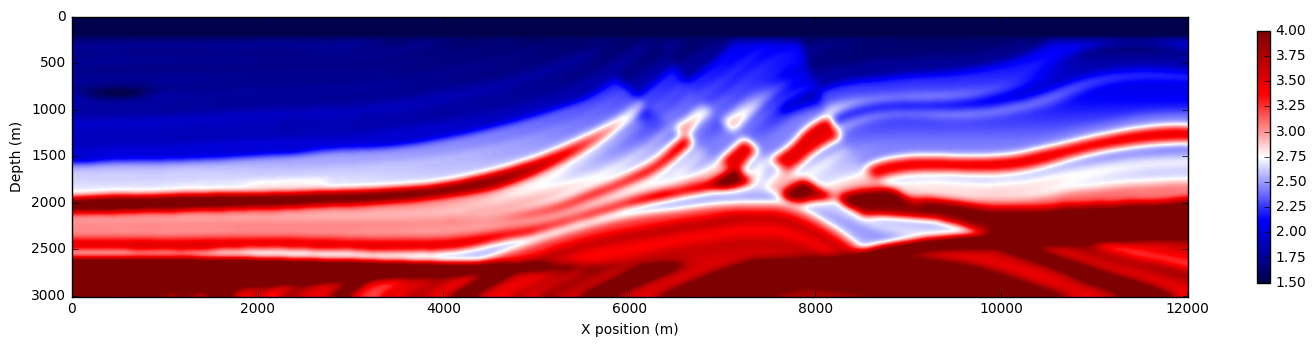

In [3]:
model0 = demo.get_initial_model()
demo.plot_velocity(model0.vp)

## Example of a shot record

In [4]:
# %load_ext snakeviz

Rewriter: 62 --> 47 flops (Gain: 1.32 X)
CustomCompiler: Compiling /tmp/devito-546850/2d4c9c5327bacbaaea231a8c33975a1e8c596c67.c
Shape: (1681 x 481) - Cache Blocking: None
Time: 189.741903 s (24 MCells/s)
Stencil: 2.937500 OI, 1.20 GFlops/s (time: 189.541378 s)
Rewriter: 62 --> 47 flops (Gain: 1.32 X)
CustomCompiler: Compiling /tmp/devito-546850/60339aae3386194cf23a6675af436e7ce14ef0b5.c
Shape: (1681 x 481) - Cache Blocking: None
Time: 187.481141 s (24 MCells/s)
Stencil: 2.937500 OI, 1.21 GFlops/s (time: 187.284949 s)


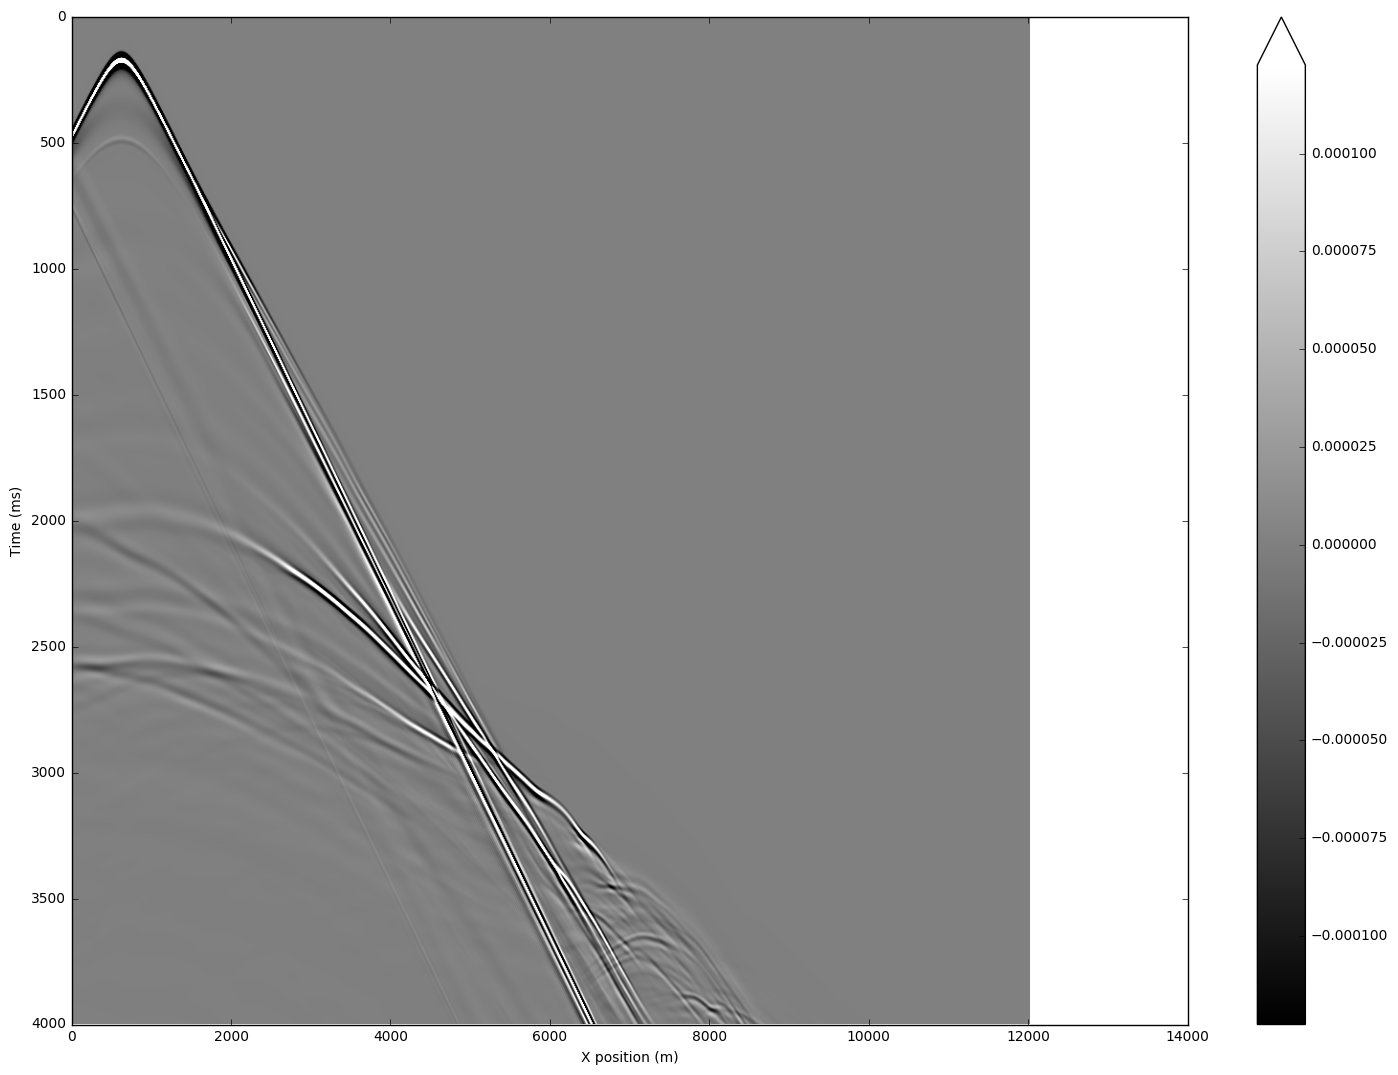

In [ ]:
# %%snakeviz
data, rec, src = demo.get_shot(50)

# Create acoustic modelling kernel.
Acoustic = Acoustic_cg(model0, data, src, t_order=2, s_order=10)

# Execute acoustic forward model.
rec0, u, gflopss, oi, timings = Acoustic.Forward(save=False, dse='advanced')

demo.plot_record(rec0)

## RTM loop

In [ ]:
# %%snakeviz
def grad_shot(i):
    demo = demo_toolkit.marmousi2D()

    model0 = demo.get_initial_model()
    data, rec, src = demo.get_shot(i)

    Acoustic0 = Acoustic_cg(model0, data, src, t_order=2, s_order=4)
    rec0, u0, gflopss, oi, timings = Acoustic0.Forward(save=True, dse='advanced')

    # Return gradient
    return Acoustic0.Gradient(rec0 - rec, u0, cache_blocking=None)

# grads = dview.map(grad_shot, range(8))
grads = map(grad_shot, range(8))

grad = sum(grads)

Rewriter: 62 --> 47 flops (Gain: 1.32 X)
CustomCompiler: Compiling /tmp/devito-546850/99e37138b95ed9e2f4be66a6c4f43ad12b1e886b.c


In [ ]:
demo.plot_rtm(grad)
# print(grad)